In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvx_portfolio as cp

plotdir = '../portfolio/plots/'

sigmas=pd.read_csv('sigmas.csv.gz',index_col=0,parse_dates=[0])
returns=pd.read_csv('returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv('volumes.csv.gz',index_col=0,parse_dates=[0])
a = pd.read_csv('a.csv.gz',index_col=0,parse_dates=[0])
b = pd.read_csv('b.csv.gz',index_col=0,parse_dates=[0])
s = pd.read_csv('s.csv.gz',index_col=0,parse_dates=[0])

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-01-01"
end_t="2016-12-29"

simulated_tcost = cp.TcostModel(volumes, sigmas, a, b, cash_key='USDOLLAR')
simulated_hcost = cp.HcostModel(s, cash_key='USDOLLAR')
simulator = cp.MarketSimulator(returns, volumes, [simulated_tcost, simulated_hcost], cash_key='USDOLLAR')

volume_estimate=pd.read_csv('volume_estimate.csv.gz',index_col=0,parse_dates=[0])
sigma_estimate=pd.read_csv('sigma_estimate.csv.gz',index_col=0,parse_dates=[0])
optimization_tcost=cp.TcostModel(volume_estimate, sigma_estimate, a, b, cash_key='USDOLLAR')
optimization_hcost=cp.HcostModel(s, cash_key='USDOLLAR')

risk_data = pd.HDFStore('risk_model.h5')
risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
all_return_estimates={}
n_p1=returns.shape[1]
T=returns.shape[0]

std_noise=0.2

np.random.seed(100)
# make new predictions
for i,t in enumerate(returns.index[:-1]):
    all_return_estimates[(t,t)]=returns.loc[t]+std_noise*np.random.randn(n_p1)
    all_return_estimates[(t,t)].USDOLLAR=returns.loc[t].ix[-1]
    tp1 = returns.index[i+1] 
    all_return_estimates[(t,tp1)]=returns.loc[tp1]+std_noise*np.random.randn(n_p1)
    all_return_estimates[(t,tp1)].USDOLLAR=returns.loc[tp1].ix[-1]
    
alpha_model = cp.MPOAlphaSource(all_return_estimates)
results_MPO={}

## MPO Coarse search 

In [ ]:
import cvxpy as cvx

policies={}
gamma_risks_coarse=[20, 60, 200, 600, 2000, 6000, 20000]
gamma_tcosts_coarse=[50, 100, 200, 500, 1000]
for gamma_risk in gamma_risks_coarse:
    for gamma_tcost in gamma_tcosts_coarse : 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.MultiPeriodOpt(alpha_model=alpha_model, 
                          costs=[gamma_risk*risk_model, gamma_tcost*optimization_tcost, optimization_hcost], 
                          constraints=[cp.LeverageLimit(3)],
                          trading_times=list(returns.index[(returns.index>=start_t)&(returns.index<=end_t)]),
                         lookahead_periods=2,
                         terminal_weights=None)

results_MPO.update({k:v for k,v in zip(policies.keys(),
                           simulator.run_multiple_backtest(w_b*1e8, start_time = start_t, end_time=end_t, 
                                          policies=policies.values(),parallel=True))})

In [ ]:
result_df_coarse=pd.DataFrame()
for k in results_MPO:
    if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
        result_df_coarse.loc[k[0], k[1]] = results_MPO[k]
        
result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]

### DOnt plot gamma trade = 30, get rid of turnover 

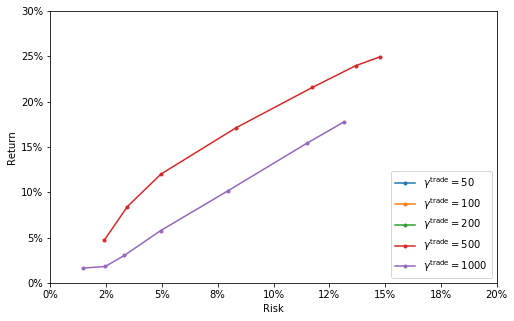

In [42]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig(plotdir+'mpo_riskrewardfrontier.png')

# MPO Pareto search 

In [13]:
results_pareto={}

In [ ]:
policies={}
#gamma_risks_pareto=[20, 35, 60, 110, 200, 350, 600, 1100, 2000, 3500, 6000, 11000, 20000]
gamma_risks_pareto=[35, 110, 350, 1100, 3500, 11000]
gamma_tcosts_pareto=[400, 450, 500,  550, 600]
gamma_holdings=[1.,10., 100.,1000.,10000.]
for gamma_risk in gamma_risks_pareto:
    for gamma_tcost in gamma_tcosts_pareto : 
        for gamma_holding in gamma_holdings:
            policies[(gamma_risk, gamma_tcost, gamma_holding)] = \
      cp.MultiPeriodOpt(alpha_model=alpha_model, 
                          costs=[gamma_risk*risk_model, gamma_tcost*optimization_tcost, 
                                 gamma_holding*optimization_hcost], 
                          constraints=[cp.LeverageLimit(3)],
                          trading_times=list(returns.index[(returns.index>=start_t)&(returns.index<=end_t)]),
                         lookahead_periods=2,
                         terminal_weights=None)

import warnings
warnings.filterwarnings('ignore')
results_pareto.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,
                                                                                end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [ ]:
table=pd.DataFrame()
table[r'$\gamma^\mathrm{risk}$']=[el[0] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{trade}$']=[el[1] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{hold}$']=['%g'%el[2] for el in results_pareto.keys()]
table['Return']=[(results_pareto[k].excess_returns.mean()*100*250) for k in results_pareto.keys()]
table['Risk']=[(results_pareto[k].excess_returns.std()*100*np.sqrt(250)) for k in results_pareto.keys()]

table = table.sort_values('Risk', ascending=False).reset_index()
del table['index']
is_pareto = lambda i: table.loc[i,'Return']>=max(table.ix[i:].Return)
table['is_pareto'] = [is_pareto(i) for i in range(len(table))]
table.to_csv('mpo_pareto_results.csv', float_format='%g')

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(table.Risk.values,table.Return.values)
plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C1.-', label='Pareto optimal frontier')
plt.legend( loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig(plotdir+'mpo_pareto.png')

In [ ]:
# table=table[table.is_pareto]
# table=table[table.Risk <= xlim]
# table=table[table.Return <= ylim]
# del table['is_pareto']
# table.Risk=table.Risk.apply(lambda x: '%.2f%%'%x)
# table.Return=table.Return.apply(lambda x: '%.2f%%'%x)
# print(table.iloc[::-1].to_latex(float_format='%.2f', escape=False, index=False).replace('%',r'\%'))

# SPO vs MPO 

In [ ]:
table_spo = pd.read_csv('spo_pareto_results.csv', index_col=0)
plt.figure(figsize=(8,5))

plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C3.-', label='MPO pareto frontier')
plt.plot(table_spo[table_spo.is_pareto].Risk,
         table_spo[table_spo.is_pareto].Return, 'C2.-', label='SPO pareto frontier')
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])
plt.savefig(plotdir+'spo_vs_mpo_pareto.png')

In [ ]:
# results_avg={}
# policies={}
# gamma_risks_coarse=[ 20, 50, 100, 200, 500, 1000, 2000]
# gamma_tcosts_coarse=[ 20, 50, 100, 200, 500, 1000, 2000]
# for gamma_risk in gamma_risks_coarse:
#     for gamma_tcost in gamma_tcosts_coarse : 
#         policies[(gamma_risk, gamma_tcost)] = \
#       cp.SinglePeriodOpt(avg_alpha_model, [gamma_risk*risk_model,gamma_tcost*optimization_tcost,optimization_hcost], 
#                                 [cp.LeverageLimit(3)])

# import warnings
# warnings.filterwarnings('ignore')
# results_avg.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
#                                               policies=policies.values(), parallel=True))))

# result_df_avg=pd.DataFrame()
# for k in results:
#     if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
#         result_df_avg.loc[k[0], k[1]] = results_avg[k]

In [ ]:
# plt.figure(figsize=(8,5))

# for gamma_tcost in result_df_MPO.columns:
#     x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df_MPO[gamma_tcost]]
#     y=[el.excess_returns.mean()*100*250 for el in result_df_MPO[gamma_tcost]]
#     plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
    
# for gamma_tcost in result_df_avg.columns:
#     x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df_avg[gamma_tcost]]
#     y=[el.excess_returns.mean()*100*250 for el in result_df_avg[gamma_tcost]]
#     plt.plot(np.array(x),np.array(y), '.--', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
    
# plt.legend(loc='lower right')
# plt.xlabel('Excess risk')
# plt.ylabel('Excess return')
# plt.xlim([0,25])
# plt.ylim([0,55])



# import matplotlib.ticker as mtick
# ax = plt.gca()
# ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
# ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

# #plt.savefig(plotdir+'mpo_riskrewardfrontier.png')